In [5]:
import os
print(os.getcwd())


c:\Users\24ksh\OneDrive\Desktop\cat vs dog\notebooks


In [9]:
import os

dataset_path = r'..\data\raw\train'  # relative path from notebooks folder
full_path = os.path.abspath(dataset_path)  # get absolute path for clarity

print("Resolved dataset path:", full_path)
print("Exists?", os.path.exists(full_path))

if os.path.exists(full_path):
    files = os.listdir(full_path)
    print("Files in dataset folder:", files[:5])  # print first 5 files
else:
    print("Dataset folder does not exist. Check your path!")


Resolved dataset path: c:\Users\24ksh\OneDrive\Desktop\cat vs dog\data\raw\train
Exists? True
Files in dataset folder: ['train']


In [25]:
dataset_path = r'../data/raw/train/train'


In [26]:
import os

files = os.listdir(dataset_path)
print("Total image files:", len(files))
print("First 5 files:", files[:5])


Total image files: 25000
First 5 files: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


In [29]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Path to your actual image folder
dataset_path = r'../data/raw/train/train'


In [28]:
filenames = os.listdir(dataset_path)
print(f"Number of files: {len(filenames)}")
print(f"First few files: {filenames[:5]}")


Number of files: 25000
First few files: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


In [30]:
# Get all image file names
filenames = [f for f in os.listdir(dataset_path) if f.lower().endswith('.jpg')]

# Create dataframe
df = pd.DataFrame({'filename': filenames})
df['label'] = df['filename'].apply(lambda x: 0 if 'cat' in x.lower() else 1)

print(df.head())
print(df['label'].value_counts())


       filename  label
0     cat.0.jpg      0
1     cat.1.jpg      0
2    cat.10.jpg      0
3   cat.100.jpg      0
4  cat.1000.jpg      0
label
0    12500
1    12500
Name: count, dtype: int64


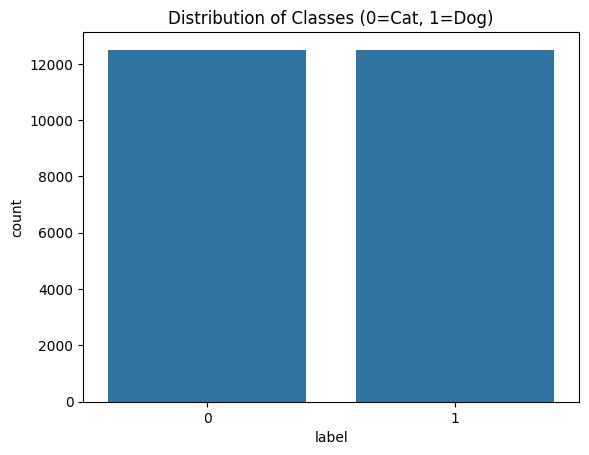

In [31]:
sns.countplot(data=df, x='label')
plt.title('Distribution of Classes (0=Cat, 1=Dog)')
plt.show()


In [32]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 20000
Test set size: 5000


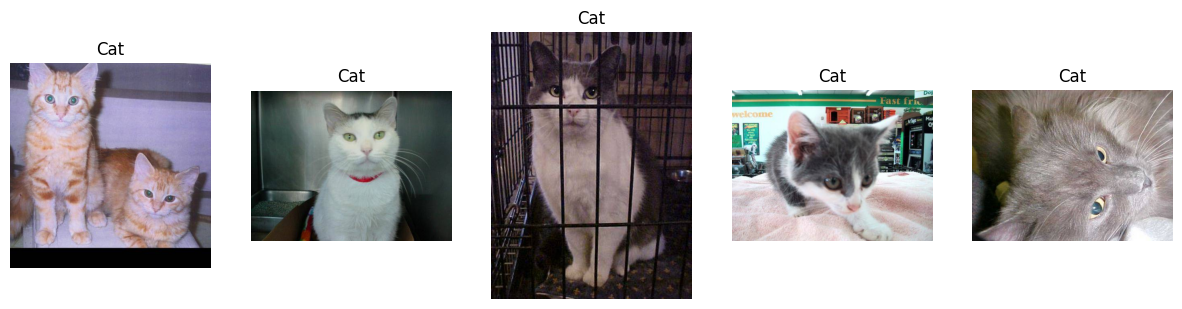

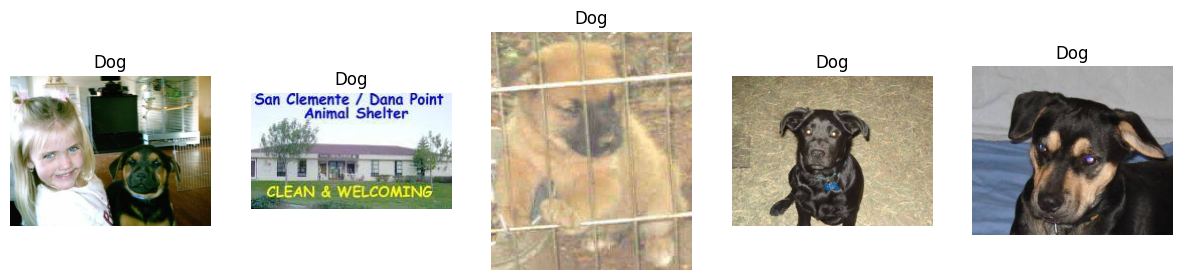

In [36]:
import matplotlib.pyplot as plt
import cv2
import os

def show_images(df, dataset_path, label, n=5):
    samples_df = df[df['label'] == label].sample(n)
    
    plt.figure(figsize=(15, 5))
    
    for i, row in enumerate(samples_df.itertuples()):
        img_path = os.path.join(dataset_path, row.filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"[ERROR] Could not read image: {img_path}")
            continue  # skip this image

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title('Cat' if label == 0 else 'Dog')
        plt.axis('off')
    
    plt.show()

# Correct image path
image_folder = '../data/raw/train/train'

# Example usage
show_images(df, image_folder, label=0, n=5)  # show 5 cat images
show_images(df, image_folder, label=1, n=5)  # show 5 dog images


In [37]:
import numpy as np

IMG_SIZE = 128  # Resize images to 128x128

def load_and_preprocess_images(df, dataset_path, img_size=IMG_SIZE):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(dataset_path, row['filename'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = cv2.resize(img, (img_size, img_size))
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
        labels.append(row['label'])
    images = np.array(images, dtype=np.float32) / 255.0  # Normalize to [0,1]
    labels = np.array(labels)
    return images, labels

X_train, y_train = load_and_preprocess_images(train_df, dataset_path)
X_test, y_test = load_and_preprocess_images(test_df, dataset_path)

print(f"Training images shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")


Training images shape: (20000, 128, 128, 3)
Training labels shape: (20000,)


In [39]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 128

# Load MobileNet base model (without top layers), pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Optional dropout to reduce overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (cat vs dog)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [40]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=10,
    verbose=1
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 131ms/step - accuracy: 0.9084 - loss: 0.2084 - val_accuracy: 0.9756 - val_loss: 0.0659
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 121ms/step - accuracy: 0.9701 - loss: 0.0776 - val_accuracy: 0.9742 - val_loss: 0.0613
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.9706 - loss: 0.0740 - val_accuracy: 0.9740 - val_loss: 0.0672
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.9769 - loss: 0.0634 - val_accuracy: 0.9764 - val_loss: 0.0619
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.9753 - loss: 0.0642 - val_accuracy: 0.9704 - val_loss: 0.0802
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - accuracy: 0.9741 - loss: 0.0662 - val_accuracy: 0.9764 - val_loss: 0.0595
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.9728 - loss: 0.0694 - val_accuracy: 0.9764 - val_loss: 0.0601
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - accuracy: 0.9739 - loss: 0

In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9779 - loss: 0.0598
Test accuracy: 0.9780
Test loss: 0.0592


In [43]:
import os
import cv2
import numpy as np
import pandas as pd

test_folder = r'../data/raw/test1/test1'  # Adjust path to your test folder
IMG_SIZE = 128

# List all test image filenames
test_filenames = os.listdir(test_folder)

# Load and preprocess images
def load_test_images(filenames, folder, img_size=IMG_SIZE):
    images = []
    valid_filenames = []
    for fname in filenames:
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = cv2.resize(img, (img_size, img_size))
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        images.append(img_rgb)
        valid_filenames.append(fname)
    images = np.array(images, dtype=np.float32) / 255.0
    return images, valid_filenames

X_test_unlabeled, valid_filenames = load_test_images(test_filenames, test_folder)
print(f"Loaded {len(X_test_unlabeled)} test images.")


Loaded 12500 test images.


In [44]:
# Predict probabilities
pred_probs = model.predict(X_test_unlabeled)

# Since your output layer uses sigmoid activation for binary classification,
# threshold at 0.5 to get class labels
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Create a DataFrame with filenames and predicted labels
results_df = pd.DataFrame({
    'filename': valid_filenames,
    'predicted_label': pred_labels
})

# Map numeric labels to string labels if you want
label_map = {0: 'cat', 1: 'dog'}
results_df['predicted_label_name'] = results_df['predicted_label'].map(label_map)

print(results_df.head())


391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step
    filename  predicted_label predicted_label_name
0      1.jpg                1                  dog
1     10.jpg                0                  cat
2    100.jpg                0                  cat
3   1000.jpg                1                  dog
4  10000.jpg                1                  dog


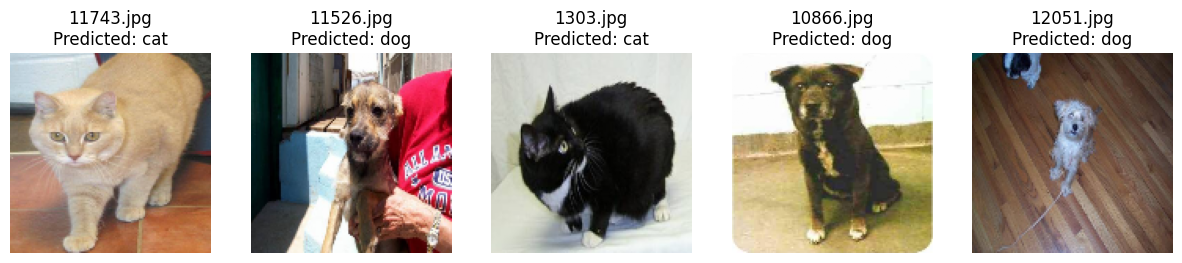

In [45]:
import matplotlib.pyplot as plt
import random

def show_predicted_images(images, filenames, pred_labels, label_map, n=5):
    plt.figure(figsize=(15, 5))
    indices = random.sample(range(len(images)), n)  # randomly select n images

    for i, idx in enumerate(indices):
        img = images[idx]
        fname = filenames[idx]
        pred_label = label_map[pred_labels[idx]]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{fname}\nPredicted: {pred_label}")
        plt.axis('off')

    plt.show()

# Call this function with your test data and predictions
show_predicted_images(X_test_unlabeled, valid_filenames, pred_labels, label_map, n=5)


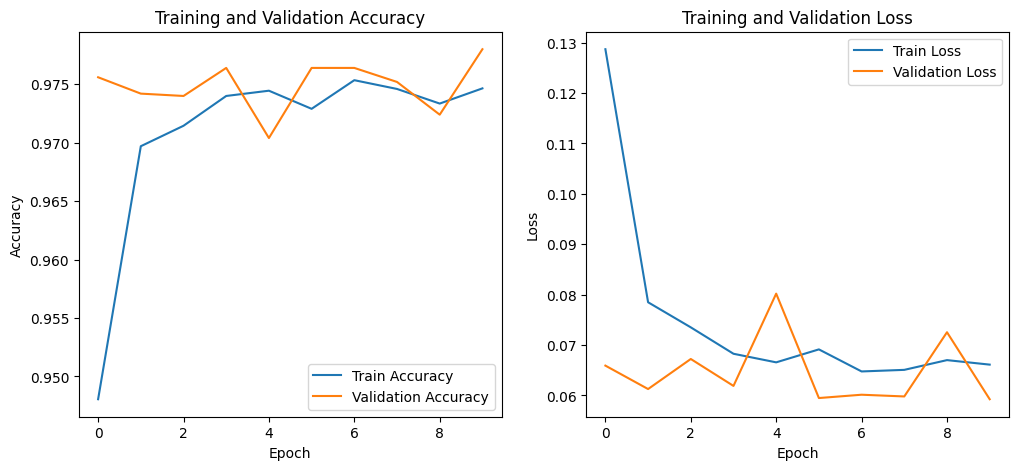

In [46]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Call this after training
plot_training_history(history)


In [50]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import cv2

upload = widgets.FileUpload(accept='image/*', multiple=False)
output = widgets.Output()  # output widget to show prediction and image

def predict_image(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # batch dimension

    pred = model.predict(img)[0][0]
    label = "Dog" if pred > 0.5 else "Cat"
    confidence = pred if pred > 0.5 else 1 - pred
    return label, confidence

def on_upload_change(change):
    with output:
        clear_output()  # clear previous outputs
        for file_info in upload.value:
            name = file_info['name']
            content = file_info['content']
            # Save uploaded file temporarily
            with open(name, 'wb') as f:
                f.write(content)
            
            label, confidence = predict_image(model, name)
            print(f"Prediction: {label} with confidence {confidence:.2f}")
            
            img = Image.open(name)
            display(img)

upload.observe(on_upload_change, names='value')
display(upload, output)


FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [52]:
model.save('cat_dog_classifier.h5')